In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv("healthcare_dataset.csv")
col_target = 'test_results'

# Hiển thị 5 dòng đầu tiên
df

,Name,Age,Gender,Blood Type,Medical Condition,Date of Admission,Doctor,Hospital,Insurance Provider,Billing Amount,Room Number,Admission Type,Discharge Date,Medication,Test Results
0,Bobby JacksOn,30,Male,B-,Cancer,2024-01-31,Matthew Smith,Sons and Miller,Blue Cross,18856.281306,328,Urgent,2024-02-02,Paracetamol,Normal
1,LesLie TErRy,62,Male,A+,Obesity,2019-08-20,Samantha Davies,Kim Inc,Medicare,33643.327287,265,Emergency,2019-08-26,Ibuprofen,Inconclusive
2,DaNnY sMitH,76,Female,A-,Obesity,2022-09-22,Tiffany Mitchell,Cook PLC,Aetna,27955.096079,205,Emergency,2022-10-07,Aspirin,Normal
3,andrEw waTtS,28,Female,O+,Diabetes,2020-11-18,Kevin Wells,"Hernandez Rogers and Vang,",Medicare,37909.782410,450,Elective,2020-12-18,Ibuprofen,Abnormal
4,adrIENNE bEll,43,Female,AB+,Cancer,2022-09-19,Kathleen Hanna,White-White,Aetna,14238.317814,458,Urgent,2022-10-09,Penicillin,Abnormal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55495,eLIZABeTH jaCkSOn,42,Female,O+,Asthma,2020-08-16,Joshua Jarvis,Jones-Thompson,Blue Cross,2650.714952,417,Elective,2020-09-15,Penicillin,Abnormal
55496,KYle pEREz,61,Female,AB-,Obesity,2020-01-23,Taylor Sullivan,Tucker-Moyer,Cigna,31457.797307,316,Elective,2020-02-01,Aspirin,Normal
55497,HEATher WaNG,38,Female,B+,Hypertension,2020-07-13,Joe Jacobs DVM,"and Mahoney Johnson Vasquez,",UnitedHealthcare,27620.764717,347,Urgent,2020-08-10,Ibuprofen,Abnormal
55498,JENniFER JOneS,43,Male,O-,Arthritis,2019-05-25,Kimberly Curry,"Jackson Todd and Castro,",Medicare,32451.092358,321,Elective,2019-05-31,Ibuprofen,Abnormal


In [3]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# Nhận biết những cột không có ý nghĩa, để xóa
def detect_useless_columns(df, uniqueness_thresh=0.95):
    drop_cols = []
    n_rows = len(df)
    
    for col in df.columns:
        nunique = df[col].nunique()
        ratio_unique = nunique / n_rows
        
        if df[col].dtype in ['object', 'category'] and ratio_unique > uniqueness_thresh:
                drop_cols.append(col)
        #elif any(key in col.lower() for key in ['id', 'name']):
        elif col.lower() in ['id', 'name', 'passengerid']:
            drop_cols.append(col)
    
    return drop_cols

def auto_clean(df, target_col):
    # 1. Chuẩn hóa tên cột
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

    # 2. Loại bỏ cột trống hoàn toàn
    df = df.dropna(axis=1, how='all')

    # 3. Loại bỏ dòng trống hoàn toàn hoặc có số mẫu ít hơn 10
    df = df.dropna(axis=0, how='all')
    value_counts = df[col_target].value_counts()
    valid_classes = value_counts[value_counts >= 10].index
    df = df[df[col_target].isin(valid_classes)].copy()

    # 4. Loại bỏ trùng lặp
    df = df.drop_duplicates()

    # 5. Làm sạch chuỗi
    for col in df.select_dtypes(include='object'):
        df[col] = df[col].str.strip()

    # 6. Xóa cột không cần thiết
    drop_cols = detect_useless_columns(df)
    df = df.drop(columns=drop_cols)

    # 7. Phân chia X và y nếu có
    has_target = target_col in df.columns
    features_df = df.drop(columns=[target_col]) if has_target else df.copy()

    # 8. Xác định cột phân loại và số
    categorical_cols = features_df.select_dtypes(include=['object', 'category']).columns.tolist()
    numerical_cols = features_df.select_dtypes(include=['int64', 'float64']).columns.tolist()

    # Nếu cột numeric có ít unique → cũng coi là categorical
    for col in features_df.columns:
        if features_df[col].nunique() < 10 and features_df[col].dtype != 'object':
            if col not in categorical_cols:
                categorical_cols.append(col)
            if col in numerical_cols:
                numerical_cols.remove(col)

    # 9. Encode categorical
    for col in categorical_cols:
        features_df[col] = LabelEncoder().fit_transform(features_df[col])

    # 10. Chuẩn hóa đặc trưng số
    if numerical_cols:
        scaler = StandardScaler()
        features_df[numerical_cols] = scaler.fit_transform(features_df[numerical_cols])

    # 11. Thêm lại cột target nếu có
    if has_target:
        cleaned_df = features_df.copy()
        y = df[target_col]

        # Nếu y không phải số nguyên, hoặc không liên tiếp từ 0 → encode
        if y.dtype == 'object' or y.dtype.name == 'category' or not np.issubdtype(y.dtype, np.integer):
            le = LabelEncoder()
            y = le.fit_transform(y)
            cleaned_df[target_col] = y
        else:
            cleaned_df[target_col] = y
    else:
        return features_df
    
    return cleaned_df

df_prf = auto_clean(df, target_col=col_target)

df_prf

,age,gender,blood_type,medical_condition,date_of_admission,doctor,hospital,insurance_provider,billing_amount,room_number,admission_type,discharge_date,medication,test_results
0,-1.098427,1,5,2,1729,26612,29933,1,-0.470713,0.233250,2,1730,3,2
1,0.533770,1,0,5,104,33648,16012,3,0.570021,-0.313520,1,109,1,1
2,1.247856,0,1,5,1233,37828,5473,0,0.169675,-0.834253,1,1247,0,2
3,-1.200439,0,6,3,560,22511,12317,3,0.870301,1.292075,0,589,1,0
4,-0.435347,0,2,2,1230,21259,33598,0,-0.795732,1.361506,2,1249,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55495,-0.486353,0,6,1,466,20003,15553,1,-1.611285,1.005672,0,495,4,0
55496,0.482764,0,3,5,260,37149,31722,2,0.416200,0.129104,0,268,0,2
55497,-0.690378,0,4,4,432,18550,37408,4,0.146144,0.398149,2,459,1,0
55498,-0.435347,1,7,0,17,22665,14329,3,0.486110,0.172498,0,22,1,0


In [4]:
# Bản dữ liệu cho SVM, RF, XGBoost (impute NaN)
df_cleaned = df_prf.copy()
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(df_cleaned.drop(columns=col_target))
imputer = SimpleImputer(strategy='most_frequent')
X_imputed = imputer.fit_transform(df_cleaned.drop(columns=col_target)).squeeze()
df_noprf = pd.DataFrame(X_imputed, columns=df_cleaned.columns[:-1])
df_noprf[col_target] = df_cleaned[col_target].values

df_noprf

,age,gender,blood_type,medical_condition,date_of_admission,doctor,hospital,insurance_provider,billing_amount,room_number,admission_type,discharge_date,medication,test_results
0,-1.098427,1.0,5.0,2.0,1729.0,26612.0,29933.0,1.0,-0.470713,0.233250,2.0,1730.0,3.0,2
1,0.533770,1.0,0.0,5.0,104.0,33648.0,16012.0,3.0,0.570021,-0.313520,1.0,109.0,1.0,1
2,1.247856,0.0,1.0,5.0,1233.0,37828.0,5473.0,0.0,0.169675,-0.834253,1.0,1247.0,0.0,2
3,-1.200439,0.0,6.0,3.0,560.0,22511.0,12317.0,3.0,0.870301,1.292075,0.0,589.0,1.0,0
4,-0.435347,0.0,2.0,2.0,1230.0,21259.0,33598.0,0.0,-0.795732,1.361506,2.0,1249.0,4.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54961,-0.486353,0.0,6.0,1.0,466.0,20003.0,15553.0,1.0,-1.611285,1.005672,0.0,495.0,4.0,0
54962,0.482764,0.0,3.0,5.0,260.0,37149.0,31722.0,2.0,0.416200,0.129104,0.0,268.0,0.0,2
54963,-0.690378,0.0,4.0,4.0,432.0,18550.0,37408.0,4.0,0.146144,0.398149,2.0,459.0,1.0,0
54964,-0.435347,1.0,7.0,0.0,17.0,22665.0,14329.0,3.0,0.486110,0.172498,0.0,22.0,1.0,0


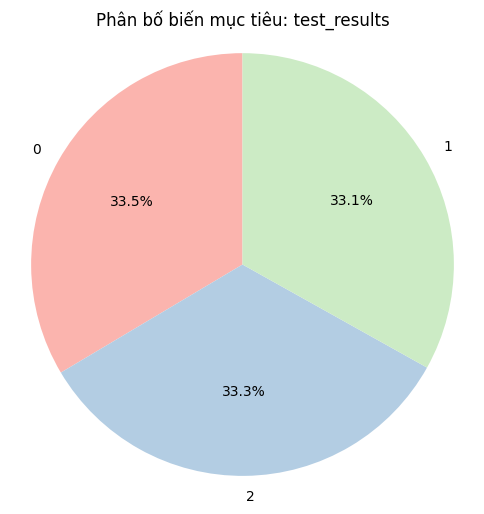

In [5]:
import matplotlib.pyplot as plt

def plot_target_pie(df, target_col):
    if target_col not in df.columns:
        print(f"Không tìm thấy cột '{target_col}' trong DataFrame.")
        return

    counts = df[target_col].value_counts()
    labels = counts.index.astype(str)
    sizes = counts.values

    plt.figure(figsize=(6,6))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=plt.cm.Pastel1.colors)
    plt.title(f'Phân bố biến mục tiêu: {target_col}')
    plt.axis('equal')  # Đảm bảo hình tròn
    plt.show()

plot_target_pie(df_prf, target_col=col_target)

In [6]:
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, log_loss, brier_score_loss, recall_score, f1_score, precision_score, ConfusionMatrixDisplay, confusion_matrix, classification_report

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import KFold   # Dùng để tạo py
from PRF import prf

In [7]:
X = df_noprf.drop(columns=[col_target])  # Drop the target column for features
y = df_noprf[col_target]
X = X.values if isinstance(X, pd.DataFrame) else X
y = y.values if isinstance(y, pd.Series) else y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [8]:
model_rf = RandomForestClassifier(n_estimators=100, max_depth=8, min_samples_split=10, random_state=42)
model_rf.fit(X_train, y_train)

y_pred = model_rf.predict(X_test)
y_proba = model_rf.predict_proba(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
lloss = log_loss(y_test, y_proba)

print(f"RF Accuracy: {accuracy:.2f}")
print(f"RF F1 Score: {f1_macro:.2f}")
print(f"RF Log Loss: {lloss:.4f}")
print(classification_report(y_test, y_pred, digits=3))

RF Accuracy: 0.35
RF F1 Score: 0.35
RF Log Loss: 1.0968
              precision    recall  f1-score   support

           0      0.344     0.438     0.386      3688
           1      0.353     0.276     0.310      3640
           2      0.360     0.339     0.349      3666

    accuracy                          0.351     10994
   macro avg      0.352     0.351     0.348     10994
weighted avg      0.352     0.351     0.348     10994



In [9]:
model_svm = SVC(kernel='rbf', C=1.0, probability=True, random_state=42)
model_svm.fit(X_train, y_train)

y_pred = model_svm.predict(X_test)
y_proba = model_svm.predict_proba(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
lloss = log_loss(y_test, y_proba)

print(f"SVM Accuracy: {accuracy:.2f}")
print(f"SVM F1 Score: {f1_macro:.2f}")
print(f"SVM Log Loss: {lloss:.4f}")
print(classification_report(y_test, y_pred, digits=3))

SVM Accuracy: 0.34
SVM F1 Score: 0.30
SVM Log Loss: 1.0988
              precision    recall  f1-score   support

           0      0.336     0.644     0.442      3688
           1      0.348     0.120     0.178      3640
           2      0.327     0.238     0.276      3666

    accuracy                          0.335     10994
   macro avg      0.337     0.334     0.299     10994
weighted avg      0.337     0.335     0.299     10994



In [11]:
model_xgb = XGBClassifier(n_estimators=100, max_depth=8, min_child_weight=10, learning_rate=0.1, eval_metric='mlogloss', random_state=42)
model_xgb.fit(X_train, y_train)

y_pred = model_xgb.predict(X_test)
y_proba = model_xgb.predict_proba(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
lloss = log_loss(y_test, y_proba)

print(f"XGB Accuracy: {accuracy:.2f}")
print(f"XGB F1 Score: {f1_macro:.2f}")
print(f"XGB Log Loss: {lloss:.4f}")
print(classification_report(y_test, y_pred, digits=3))

XGB Accuracy: 0.38
XGB F1 Score: 0.38
XGB Log Loss: 1.0949
              precision    recall  f1-score   support

           0      0.366     0.379     0.373      3688
           1      0.376     0.378     0.377      3640
           2      0.385     0.369     0.377      3666

    accuracy                          0.376     10994
   macro avg      0.376     0.376     0.376     10994
weighted avg      0.376     0.376     0.376     10994



In [12]:
X = df_prf.drop(columns=[col_target])  # Drop the target column for features
y = df_prf[col_target]
X = X.values if isinstance(X, pd.DataFrame) else X
X = X.astype(float)  # BẮT BUỘC để tránh lỗi NaN với dtype=int
y = y.values if isinstance(y, pd.Series) else y

In [13]:
# Tính noise_level khi missing data

from sklearn.ensemble import IsolationForest

def safe_impute(X, strategy="median"):
    X = X.copy()
    from sklearn.impute import SimpleImputer
    imp = SimpleImputer(strategy=strategy)
    return imp.fit_transform(X)

def estimate_noise_level_from_outliers(X):
    X_filled = safe_impute(X, strategy='median')
    iso = IsolationForest(contamination=0.1, random_state=42)
    preds = iso.fit_predict(X_filled)
    outlier_ratio = np.mean(preds == -1)
    return np.clip(outlier_ratio * 2.0, 0.01, 1.0)

def estimate_noise_level_from_variance(X):
    X_filled = np.nan_to_num(X, nan=0.0)  # hoặc median nếu bạn muốn chính xác hơn
    stds = np.std(X_filled, axis=0)
    means = np.mean(np.abs(X_filled), axis=0) + 1e-6
    relative_noise = stds / means
    return np.clip(relative_noise.mean(), 0.01, 1.0)

def estimate_noise_level(X):
    var_score = estimate_noise_level_from_variance(X)
    outlier_score = estimate_noise_level_from_outliers(X)
    return np.clip((var_score + outlier_score) / 2, 0.01, 1.0)

# Gán độ nhiễu tương ứng
noise_level = estimate_noise_level(X)
dX = noise_level * np.abs(np.nan_to_num(X, nan=1.0)) + 0.01

noise_level

np.float64(0.41455514624762324)

In [14]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
n_classes = len(np.unique(y))
py = np.zeros((len(X), n_classes))

for train_idx, val_idx in kf.split(X):
    rf = RandomForestClassifier(n_estimators=50, max_depth=8, n_jobs=-1, random_state=41)
    rf.fit(X[train_idx], y[train_idx])
    py[val_idx] = rf.predict_proba(X[val_idx])

py

array([[0.3378606 , 0.33329339, 0.32884601],
       [0.34393175, 0.32337439, 0.33269386],
       [0.33838163, 0.35080846, 0.31080991],
       ...,
       [0.32731278, 0.32816666, 0.34452056],
       [0.3500384 , 0.30911066, 0.34085094],
       [0.34056764, 0.3312975 , 0.32813486]], shape=(54966, 3))

In [15]:
X_train, X_test, dX_train, dX_test, py_train, py_test = train_test_split(
    X, dX, py, test_size=0.2, random_state=40, stratify=np.argmax(py, axis=1)
)

model_prf = prf(n_estimators=100, bootstrap=True, max_depth=8, keep_proba=1.0, n_jobs=-1)
model_prf.fit(X=X_train, dX=dX_train, py=py_train)

y_test_bin = py_test.argmax(axis=1)
y_proba_prf = np.array(model_prf.predict_proba(X_test, dX=dX_test))
y_pred_prf = y_proba_prf.argmax(axis=1)
f1_macro = f1_score(y_test_bin, y_pred_prf, average='macro')
lloss = log_loss(y_test_bin, y_proba_prf)

print("PRF Accuracy:", model_prf.score(X_test, dX=dX_test, y=y_test_bin))
print(f"PRF F1 Score: {f1_macro:.2f}")
print(f"PRF Log Loss: {lloss:.4f}")
print(classification_report(y_test_bin, y_pred_prf, digits=3))

PRF Accuracy: 0.5351100600327451
PRF F1 Score: 0.48
PRF Log Loss: 1.0929
              precision    recall  f1-score   support

           0      0.527     0.795     0.634      4694
           1      0.578     0.212     0.310      2944
           2      0.540     0.455     0.494      3356

    accuracy                          0.535     10994
   macro avg      0.548     0.487     0.479     10994
weighted avg      0.544     0.535     0.504     10994

